# Yeast Data Set 
## Description

Data set of yeast samples containing their attributes as well as the localization of their proteins within the sample.

The column attributes are as follows:

| Id | Attribute |Domain |
| -   | ----------- |----------- |
| 1   | Sequence Name | Number and letter sequence. |
| 2   |  McGeoch's method for signal sequence recognition.   | 0 - 1 |
| 3   | Von Heijne's method for signal sequence recognition. |0 - 1 |
| 4   | Score of the ALOM membrane spanning region prediction program. | 0 - 1 |
| 5   | Score of discriminant analysis of the amino acid content of the N-terminal region. | 0 - 1 |
| 6   | Presence of "HDEL" substring (thought to act as a signal forretention in the endoplasmic reticulum lumen).Binary attribute. | 0 or 0.5 |
| 7   | Peroxisomal targeting signal in the C-terminus.   |0 - 1 |
| 8   |  Score of discriminant analysis of the amino acid content of vacuolar and extracellular proteins.| 0 - 1 |
| 9   | Score of discriminant analysis of nuclear localization signals of nuclear and non-nuclear proteins.| 0 - 1 |
| 10  | The class of the yeast sample. | Location ID |

## Importing the Dataset

In [1]:
import numpy as np
import pandas as pd

In [4]:
headers = ['Sequence_name','MCG','GVH','ALM','MIT', 'ERL','POX','VAC','NUC', 'Class']
data = pd.read_csv("../../datasets/classification/yeast-data", header = None, names = headers, delimiter=r"\s+")

## Preparing the Dataset

In [12]:
from sklearn.model_selection import train_test_split

X = (data.iloc[:,1:data.shape[1]-1]).to_numpy().flatten().reshape(data.shape[0],-1)
y = data.iloc[:,data.shape[1]-1:data.shape[1]]

y.Class = pd.Categorical(y.Class)
y.Class = y.Class.cat.codes
y = y.to_numpy().flatten()

X_train, X_test, y_train, y_test= train_test_split(X, y, train_size=0.80, test_size = 0.20, random_state=0)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, train_size=0.75, test_size = 0.25, random_state=0)

The following block prints the shape and column datatypes of the processed dataset.

In [13]:
print(data.shape)
print(data.dtypes)

(1484, 10)
Sequence_name     object
MCG              float64
GVH              float64
ALM              float64
MIT              float64
ERL              float64
POX              float64
VAC              float64
NUC              float64
Class             object
dtype: object


## Train on Multiple Classifiers

In [14]:
# Manage imports
import sklearn.linear_model
import sklearn.tree
import sklearn.ensemble
import sklearn.neighbors
from sklearn.naive_bayes import GaussianNB
from utilities import train_estimators, plot_estimator_scores

### Logistic Regression Classification

Training LogisticRegression(C=1e-05, max_iter=10000, random_state=0)...
Training LogisticRegression(C=0.0001, max_iter=10000, random_state=0)...
Training LogisticRegression(C=0.001, max_iter=10000, random_state=0)...
Training LogisticRegression(C=0.01, max_iter=10000, random_state=0)...
Training LogisticRegression(C=0.1, max_iter=10000, random_state=0)...
Training LogisticRegression(C=1.0, max_iter=10000, random_state=0)...


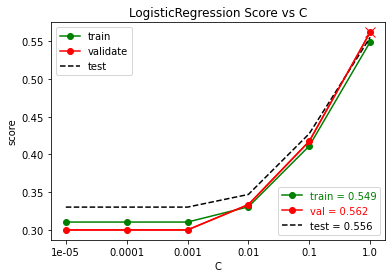

In [16]:
adjusted_parameter = 'C'
adjusted_parameter_values = [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0]

LogisticRegressionEstimators = train_estimators(X_train, y_train,
                                                sklearn.linear_model.LogisticRegression,
                                                adjusted_parameter,
                                                adjusted_parameter_values,
                                                max_iter=10000,
                                                random_state=0)
plot_estimator_scores(LogisticRegressionEstimators,
                      adjusted_parameter,adjusted_parameter_values,
                      X_train, y_train, X_test, y_test, X_val, y_val)

### SVM Classification

Training SVC(C=0.01, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=0.1, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=1.0, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=10.0, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=100.0, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=1000.0, gamma=0.0001, max_iter=10000, random_state=0)...


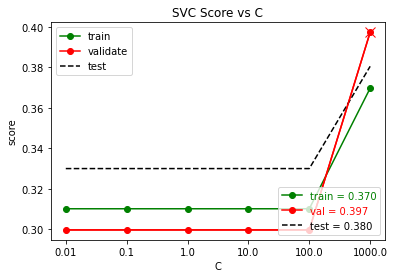

In [17]:
adjusted_parameter = 'C'
adjusted_parameter_values = [0.01, 0.1,1.0,10.0,100.0,1000.0]

SVMEstimators = train_estimators(X_train, y_train,
                                    sklearn.svm.SVC,
                                    adjusted_parameter, adjusted_parameter_values,
                                    gamma=0.0001,
                                    max_iter=10000,
                                    random_state=0)

plot_estimator_scores(SVMEstimators,
                      adjusted_parameter, adjusted_parameter_values,
                      X_train, y_train, X_test, y_test, X_val, y_val)

### Decision Tree Classification

Training DecisionTreeClassifier(max_depth=1, splitter='random', random_state=0)...
Training DecisionTreeClassifier(max_depth=5, splitter='random', random_state=0)...
Training DecisionTreeClassifier(max_depth=10, splitter='random', random_state=0)...
Training DecisionTreeClassifier(max_depth=20, splitter='random', random_state=0)...
Training DecisionTreeClassifier(max_depth=50, splitter='random', random_state=0)...
Training DecisionTreeClassifier(max_depth=100, splitter='random', random_state=0)...


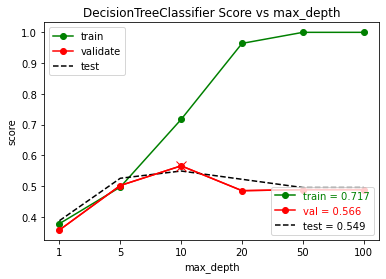

In [19]:
adjusted_parameter = 'max_depth'
adjusted_parameter_values = [1, 5, 10, 20, 50, 100]

DecisionTreeEstimators = train_estimators(X_train, y_train,
                                            sklearn.tree.DecisionTreeClassifier,
                                            adjusted_parameter, adjusted_parameter_values,
                                            splitter='random',
                                            random_state=0)
plot_estimator_scores(DecisionTreeEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        X_train, y_train, X_test, y_test, X_val, y_val)

### RandomForest Classification

Training RandomForestClassifier(max_depth=1, random_state=0)...
Training RandomForestClassifier(max_depth=5, random_state=0)...
Training RandomForestClassifier(max_depth=10, random_state=0)...
Training RandomForestClassifier(max_depth=20, random_state=0)...
Training RandomForestClassifier(max_depth=50, random_state=0)...
Training RandomForestClassifier(max_depth=100, random_state=0)...


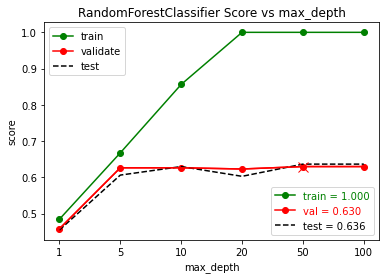

In [20]:
adjusted_parameter = 'max_depth'
adjusted_parameter_values = [1, 5, 10, 20, 50, 100]

RandomTreeEstimators = train_estimators(X_train, y_train,
                                        sklearn.ensemble.RandomForestClassifier,
                                        adjusted_parameter, adjusted_parameter_values,
                                        random_state=0)
plot_estimator_scores(RandomTreeEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        X_train, y_train, X_test, y_test, X_val, y_val)

### K-nearest Classification

Training KNeighborsClassifier(weights=uniform, n_neighbors=2)...
Training KNeighborsClassifier(weights=distance, n_neighbors=2)...


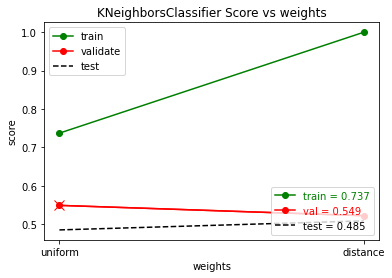

In [21]:
adjusted_parameter = 'weights'
adjusted_parameter_values = ['uniform','distance']

KNearestEstimators = train_estimators(X_train, y_train,
                                        sklearn.neighbors.KNeighborsClassifier,
                                        adjusted_parameter, adjusted_parameter_values,
                                        n_neighbors=2)
plot_estimator_scores(KNearestEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        X_train, y_train, X_test, y_test, X_val, y_val)

Training KNeighborsClassifier(algorithm=auto, n_neighbors=2)...
Training KNeighborsClassifier(algorithm=ball_tree, n_neighbors=2)...
Training KNeighborsClassifier(algorithm=kd_tree, n_neighbors=2)...
Training KNeighborsClassifier(algorithm=brute, n_neighbors=2)...


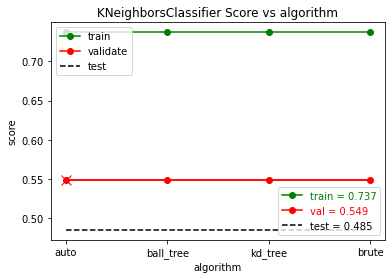

In [22]:
adjusted_parameter = 'algorithm'
adjusted_parameter_values = ['auto', 'ball_tree', 'kd_tree','brute']

KNearestEstimators = train_estimators(X_train, y_train,
                                        sklearn.neighbors.KNeighborsClassifier,
                                        adjusted_parameter, adjusted_parameter_values,
                                        n_neighbors=2)
plot_estimator_scores(KNearestEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        X_train, y_train, X_test, y_test, X_val, y_val)

## Ada Boost Classification

Training AdaBoostClassifier(n_estimators=10, random_state=0)...
Training AdaBoostClassifier(n_estimators=50, random_state=0)...
Training AdaBoostClassifier(n_estimators=100, random_state=0)...
Training AdaBoostClassifier(n_estimators=500, random_state=0)...
Training AdaBoostClassifier(n_estimators=1000, random_state=0)...
Training AdaBoostClassifier(n_estimators=5000, random_state=0)...


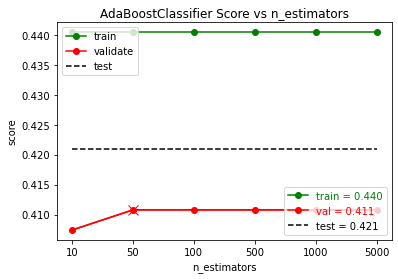

In [23]:
adjusted_parameter = 'n_estimators'
adjusted_parameter_values = [10, 50, 100, 500, 1000, 5000]

AdaBoostEstimators = train_estimators(X_train, y_train,
                                        sklearn.ensemble.AdaBoostClassifier,
                                        adjusted_parameter, adjusted_parameter_values,
                                        random_state=0)
plot_estimator_scores(AdaBoostEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        X_train, y_train, X_test, y_test, X_val, y_val)

## Gaussian Naive Bayes Classification

In [24]:
clf = GaussianNB()
NaiveBayesEstimator=clf.fit(X_train, y_train)
NB_training_scores = NaiveBayesEstimator.score(X_train, y_train)
NB_test_scores =  NaiveBayesEstimator.score(X_test, y_test)
NB_val_scores =  NaiveBayesEstimator.score(X_val, y_val)
print(NB_training_scores,NB_val_scores,NB_test_scores)

0.20337078651685395 0.20875420875420875 0.14814814814814814
